# Stage modelling from spatial features

In [1]:
import os
import numpy as np
import anndata as ad
import pandas as pd
from plotnine import *

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
import scanpy as sc
from joblib import Parallel, delayed
import warnings, logging

import shap

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Overall cell features

In [2]:
cell_table = pd.read_csv("../../data/cell_table_with_types_stage.csv", 
                         index_col = 0)

/tmp/ipykernel_112000/1000358550.py:1: DtypeWarning: Columns (39,40,41,42,43,44,45,46,48,49,52,53,54,55,56,57,58,59,60,61,62,63,65,66,68) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
metab_markers = ['CA9', 'CD98', 'CytC', 'MCT1', 'ASCT2', 'LDH', 'GS', 'GLS', 'ATP5A', 'CS', 'PKM2', 'GLUT1', 'ARG1', 'CPT1A', 'Ki67']

# Only metabolic markers for cancer/epithelial cells
df = cell_table.loc[cell_table.consensus == "Cancer_cell",metab_markers] 
meta = cell_table.loc[cell_table.consensus == "Cancer_cell",["Stage","fov"]]

# A few FOVs show only few epithelial cells and might only add noise to the analysis
sparse_epi_fovs = meta.fov.value_counts()[meta.fov.value_counts() <= 20].index
df = df.loc[~meta.fov.isin(sparse_epi_fovs)]
meta = meta.loc[~meta.fov.isin(sparse_epi_fovs)]

# Only keep well-annotated cancer stages
epithelial_subset = meta["Stage"].isin(["pT1", "pT2", "pT3", "pT4"]).values

We choose to perform the prediction task on well annotated FOVs with sufficient epithelial cells.
```python
# Note: 13 FOVs are not annotated as healthy or to a specific cancer stage
cell_table.loc[cell_table.fov.isin(meta.loc[~epithelial_subset].fov), "fov"].unique()

# Additionally, 7 FOVs do not contain epithelial cells and are therefore lost
set(cell_table.fov) - set(meta.fov)

# Finally, we also exclude 27 FOVs that contain only few epithelial cells
# The rationale is to compare on the cellular organization around the colorectal epithelium
set(sparse_epi_fovs)
```

In [4]:
# The least represented conditions are mostly unaffected
print(cell_table.groupby("fov").first().Stage.value_counts())
print(meta.loc[epithelial_subset].groupby("fov").first().Stage.value_counts())

Stage
pT3          234
pT4          105
pT2           92
pT1           19
SCT            6
Colon-no.      5
Name: count, dtype: int64
Stage
pT3    218
pT4     97
pT2     85
pT1     18
Name: count, dtype: int64


## Prepare cross-validation

In [5]:
# Define which fovs will be held out for validation (outer loop)
fov_stage_table = meta.loc[epithelial_subset].drop_duplicates().reset_index(drop=True)
fov_inner, fov_val, y_inner, y_val = train_test_split(
    fov_stage_table["fov"], fov_stage_table["Stage"], test_size=0.2, random_state=0, stratify=fov_stage_table["Stage"])
meta["inner"] = meta["fov"].isin(fov_inner)
# For sanity check, the following should consistently be used as validation set
" ".join(fov_val.sort_values())

'A1a A1f A1h A2g A2i A2q A2r A3m A4e A4n A5a A5q A6b A6c A6g A6m A6p A6q A6r A7f A7p A8a A8m A9o A9q B1h B1k B2a B2b B2k B2o B3c B3g B4b B4g B4m B6i B6q B7c B7p B7r B8b B8d B8g B8i B8l B9c B9d B9h B9m B9n B9o C1i C1l C2a C2f C2k C3c C3h C4a C4g C4k C5a C5k C5l C6d C8a C8h D1i D1l D1m D2e D2k D4c D5b D5d D5h D5k D5l D6c D6k D7a D8d D8h'

In [6]:
n_splits = 4

cv_folds = StratifiedGroupKFold(n_splits=n_splits)
for train, test in cv_folds.split(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
                                  meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
                                  groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]):
    # All stages should be present in both train and test
    assert len(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov")["Stage"].first().unique()) == 4
    assert len(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[train].groupby("fov")["Stage"].first().unique()) == 4
    # Print the first test FOVs
    print(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov").first().index[:5]) 

Index(['A1e', 'A1n', 'A3b', 'A3d', 'A3e'], dtype='object', name='fov')
Index(['A1c', 'A1m', 'A1o', 'A1p', 'A1q'], dtype='object', name='fov')
Index(['A1l', 'A1r', 'A2b', 'A2c', 'A2l'], dtype='object', name='fov')
Index(['A1d', 'A1i', 'A1k', 'A2a', 'A2d'], dtype='object', name='fov')


We can split the data at the cell level to allow applications that involve processing single cells. The grouping ensures that the data is split per FOV without contamination (i.e. cells from a given FOV present both in training and testing).

In [7]:
meta
meta_per_fov = meta.loc[epithelial_subset].groupby("fov").first()

In [8]:
df_per_fov = df.copy()
df_per_fov["fov"] = meta["fov"] 
df_per_fov = df_per_fov.loc[epithelial_subset].groupby("fov").mean()
meta_per_fov = meta.loc[epithelial_subset].groupby("fov").first()

Alternatively, we directly split the FOVs, for applications that involve FOV-level features. 
Note: we could generate independent folds, but the FOV distribution would not be identical.
We choose to directly define the folds to be the same to make results more comparable.
```Python
cv_folds_fov = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2020)
for train, test in cv_folds_fov.split(df_per_fov.loc[meta_per_fov["inner"]],
                                      meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
                                    ):
    # All stages should be present in both train and test
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"].unique()) == 5
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"].unique()) == 5
    # Print the first test FOVs
    print(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test].index[:5]) 

```

In [9]:
def conv_traintest_cells_to_fov():
    for train, test in cv_folds.split(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
                                    meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
                                    groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]):
        test_fovs = meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov").first().index
        train_fovs = meta.loc[epithelial_subset].loc[meta["inner"]].iloc[train].groupby("fov").first().index
        test_fovs_ind = np.where(meta_per_fov.loc[meta_per_fov["inner"]].index.isin(test_fovs))[0]
        train_fovs_ind = np.where(meta_per_fov.loc[meta_per_fov["inner"]].index.isin(train_fovs))[0]
        yield (train_fovs_ind, test_fovs_ind)

# Should work as the output of `split` method: two arrays of indices
cv_folds_fov = [x for x in conv_traintest_cells_to_fov()]

for train, test in cv_folds_fov:
    # All stages should be present in both train and test
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"].unique()) == 4
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"].unique()) == 4
    # Print the first test FOVs
    print(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test].index[:5])

Index(['A1e', 'A1n', 'A3b', 'A3d', 'A3e'], dtype='object', name='fov')
Index(['A1c', 'A1m', 'A1o', 'A1p', 'A1q'], dtype='object', name='fov')
Index(['A1l', 'A1r', 'A2b', 'A2c', 'A2l'], dtype='object', name='fov')
Index(['A1d', 'A1i', 'A1k', 'A2a', 'A2d'], dtype='object', name='fov')


## Model 0: Baseline (most abundant label)

In [10]:
np.mean([f1_score(LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]),
                [2 for _ in range(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test].shape[0])],
                average="macro")
                for train, test in cv_folds_fov])

0.17126558017457122

In [11]:
for train, test in cv_folds_fov:
    y_train = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
    y_test = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]
    
    le = LabelEncoder()
    baseline_f1_scores = [f1_score(
                            le.fit_transform(y_test),
                            np.random.randint(0,5,y_test.shape[0]),
                            average="macro")
                        for _ in range(1000)]
    print(f"Baseline: {np.mean(baseline_f1_scores)} (95% CI: {np.percentile(baseline_f1_scores, 2.5)}-{np.percentile(baseline_f1_scores, 97.5)})")
baseline_f1 = np.mean(baseline_f1_scores)

Baseline: 0.15100332039309483 (95% CI: 0.08878362808056336-0.21684619547119544)
Baseline: 0.1527473620667609 (95% CI: 0.08719358090924505-0.2245408518194715)
Baseline: 0.15561370514650916 (95% CI: 0.08650731153620765-0.22522938683700186)
Baseline: 0.15259903662141608 (95% CI: 0.09076729626485569-0.2257209898159449)


In [12]:
all_f1_scores = []
for train, test in cv_folds_fov:
    y_train = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
    y_test = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]
    
    le = LabelEncoder()
    baseline_f1_scores = [f1_score(
                            le.fit_transform(y_test),
                            le.transform(np.random.choice(y_train, len(y_test), replace=True)),
                            average="macro")
                        for _ in range(1000)]
    print(f"Baseline: {np.mean(baseline_f1_scores)} (95% CI: {np.percentile(baseline_f1_scores, 2.5)}-{np.percentile(baseline_f1_scores, 97.5)})")
    all_f1_scores.append(baseline_f1_scores)
# Expectation of performance across all folds
all_f1_scores = np.array(all_f1_scores)
print(f"Baseline: {np.mean(np.mean(all_f1_scores, axis=0))} (95% CI: {np.mean(np.percentile(all_f1_scores, 2.5, axis=0))}-{np.mean(np.percentile(all_f1_scores, 97.5, axis=0))})")
baseline_f1 = np.mean(all_f1_scores)

Baseline: 0.2482835526268756 (95% CI: 0.16574470256535476-0.3573355243174035)
Baseline: 0.25038123934025647 (95% CI: 0.17056454192840748-0.3538640163605964)
Baseline: 0.24634267641156635 (95% CI: 0.16666008192761905-0.3460280809959118)
Baseline: 0.24351602386019636 (95% CI: 0.1679207517810949-0.3538240625848229)
Baseline: 0.24713087305972367 (95% CI: 0.20376592140227548-0.29411450224060104)


## Model 1: Cell type composition

In [13]:
cell_type_proportions = cell_table.groupby("fov")["consensus"].value_counts().unstack().fillna(0)
# Normalize by the number of cells in each FOV
cell_type_proportions = cell_type_proportions.div(cell_type_proportions.sum(axis=1), axis=0)
# Match to metadata and kept FOVs
cell_type_proportions = cell_type_proportions.loc[meta_per_fov.index]

In [14]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"])
)

In [15]:
scores = cross_val_score(
    XGBClassifier(
        n_estimators=250, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    cell_type_proportions.loc[meta_per_fov["inner"]],
    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
    cv=cv_folds_fov, 
    params={'sample_weight':sample_weights},
    scoring='f1_macro')
np.mean(scores)

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:31:46] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



0.2945848570157424

For cell type composition, XGBoost seems appropriate (good performance, and in practice a bit more stable than RF, although slower).
```Python
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Define models and their hyperparameters
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'SVM': SVC(),
    'LogisticRegression': LogisticRegression()
}

params = {
    'RandomForest': {
        'n_estimators': [20, 50, 100, 200, 300],
        'max_depth': [2, 3, 5]
    },
    'XGBoost': {
        'n_estimators': [20, 50, 100, 200, 300],
        'max_depth': [2, 3, 5],
        'device': ['cuda'],
        'random_state': [0]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs']
    }
}

# Perform GridSearchCV for each model
best_models = {}
best_scores = {}
for model_name in models:
    grid_search = GridSearchCV(models[model_name], params[model_name], cv=cv_folds_fov, scoring='f1_macro')
    grid_search.fit(cell_type_proportions.loc[meta_per_fov["inner"]], 
                    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
                    sample_weight=sample_weights)
    best_models[model_name] = grid_search.best_estimator_
    best_scores[model_name] = grid_search.best_score_

# Print the best models and their parameters
for model in best_models.keys():
    print(model, best_models[model])
    print("Best score:", best_scores[model])
```

In [44]:
def process_fold_composition(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):      
        # Step 1: Define train and test subsets of the compositional data
        train_composition = cell_type_proportions.loc[meta_per_fov["inner"]].iloc[train]
        test_composition = cell_type_proportions.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]

        # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = RandomForestClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            # device="cuda", 
            random_state=0)
        xgb.fit(train_composition,
                LabelEncoder().fit_transform(train_meta),
                sample_weight=sample_weights[train])

        # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_composition)

        # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [45]:
def test_estimator_composition(estimators, depth=4):
    scores = [process_fold_composition(train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.mean(scores)
    # Append to f1 score log file
    with open(f"../../data/model1_rf_cell_composition_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    print(estimators, depth, mean_score)
    return mean_score

In [46]:
# Parallelize the hyperparameter loop | ~81mn
np.random.seed(0)
estimator_range = np.arange(15, 511, 10)
depth_range = np.arange(3, 10, 2)
estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
Parallel(n_jobs=28)(delayed(test_estimator_composition)(r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()))

15 3 0.3253395906099134
25 3 0.3222138300835936
35 3 0.33228202597323575
45 3 0.3287426839828401
55 3 0.3277648352921843
65 3 0.32537709324739866
75 3 0.31290438956525235
85 3 0.30591298961419133
95 3 0.2965746041229584
105 3 0.292706736621989
125 3 0.2927553727788813
115 3 0.315708045127514
135 3 0.289675552278779
145 3 0.2873221352874231
155 3 0.2963757054437813
185 3 0.2950259994535205
195 3 0.3002166290501832
165 3 0.3187596392502635
175 3 0.30208822211894976
235 3 0.28560267156172503
205 3 0.3036727164445742
225 3 0.2949900326781095
215 3 0.2945621451853183
15 5 0.3006719484080007
305 3 0.28378894800258914
295 3 0.281540119920176
25 5 0.3069362414262923
35 5 0.30113553199009524
345 3 0.29886288934967997
45 5 0.30038238018325036
355 3 0.29089946823184026
55 5 0.2992515386037126
335 3 0.28987982996285133
315 3 0.2854241620254582
65 5 0.30157032095568714
375 3 0.2917780108331417
75 5 0.27360136410420943
365 3 0.2891977341642155
85 5 0.2804743172350835
385 3 0.2853407367371978
245 3 0

[0.3253395906099134,
 0.3222138300835936,
 0.33228202597323575,
 0.3287426839828401,
 0.3277648352921843,
 0.32537709324739866,
 0.31290438956525235,
 0.30591298961419133,
 0.2965746041229584,
 0.292706736621989,
 0.315708045127514,
 0.2927553727788813,
 0.289675552278779,
 0.2873221352874231,
 0.2963757054437813,
 0.3187596392502635,
 0.30208822211894976,
 0.2950259994535205,
 0.3002166290501832,
 0.3036727164445742,
 0.2945621451853183,
 0.2949900326781095,
 0.28560267156172503,
 0.2852270815835831,
 0.28131575035592893,
 0.2843030817496921,
 0.2790754668635485,
 0.2818701897881587,
 0.281540119920176,
 0.28378894800258914,
 0.2854241620254582,
 0.28967373701020016,
 0.28987982996285133,
 0.29886288934967997,
 0.29089946823184026,
 0.2891977341642155,
 0.2917780108331417,
 0.2853407367371978,
 0.28312561220166993,
 0.28755734972431657,
 0.2977065530346822,
 0.2948684478375213,
 0.29420063216700487,
 0.294139204167144,
 0.29038817110091214,
 0.29042896299831783,
 0.28598139769033554,


In [48]:
pd.read_csv("../../data/model1_rf_cell_composition_f1_scores.txt", header=None, names=["estimators", "score"]).sort_values("score", ascending=False).head(10)

,estimators,score
35,3,0.332282
45,3,0.328743
55,3,0.327765
65,3,0.325377
15,3,0.325340
25,3,0.322214
165,3,0.318760
115,3,0.315708
75,3,0.312904
25,5,0.306936


## Model 2: Metabolic clusters
See *MetabViz.ipynb* for details.

In [22]:
cross_val_score(
    XGBClassifier(
        n_estimators=250, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
    LabelEncoder().fit_transform(meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"]),
    groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"], 
    cv=cv_folds, 
    scoring='f1_macro')

array([0.24052244, 0.25562628, 0.26094669, 0.23319986])

In [23]:
pd.read_csv("../../data/cluster_f1_scores.txt").sort_values("score", ascending=False).head(10)

,resolution,neighbors,estimators,score
153,0.23,5,169,0.369303
68,0.90,5,440,0.360735
56,0.13,11,31,0.355948
352,0.63,3,268,0.354892
140,0.86,4,369,0.351360
47,0.29,2,228,0.350469
48,0.29,2,242,0.348103
172,0.58,2,356,0.345388
315,0.35,9,165,0.342340
271,0.41,6,448,0.341682


In [54]:
res = 0.23
neighbors = 5
estimators = 169

In [18]:
def process_fold(train, test, n_neighbors = 30, resolution = 0.5, n_estimators = 250):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):
        # Step 1: Define metabolic clusters on training data
        ad = sc.AnnData(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]].iloc[train])
        sc.pp.neighbors(ad, n_neighbors=n_neighbors)
        sc.tl.leiden(ad, resolution=resolution)
        ad.obs.leiden = ad.obs.leiden.values.astype(int)

        # Step 2: Define a classifier to propagate the clusters to the test data
        neigh = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)
        neigh.fit(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]].iloc[train].values, 
                ad.obs.leiden.values)

        # Step 3: Compute proportion of cells in each cluster for each FOV in the training data
        train_fov_cluster_composition = pd.DataFrame(ad.obs.leiden.values, columns=["Cluster"])
        train_fov_cluster_composition["fov"] = (
            meta.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]].iloc[train]["fov"].values
        )
        train_fov_cluster_composition = (
            train_fov_cluster_composition.groupby("fov")["Cluster"].value_counts().unstack().fillna(0)
        )
        # Normalize by the number of cells in each FOV
        train_fov_cluster_composition = (
            train_fov_cluster_composition.div(train_fov_cluster_composition.sum(axis=1), axis=0)
        )

        # Step 4: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=3, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_fov_cluster_composition,
                LabelEncoder().fit_transform(meta.loc[epithelial_subset].loc[meta["inner"]].groupby("fov").first()["Stage"].loc[train_fov_cluster_composition.index]))
        
        # Step 5: Predict clusters on test data
        test_clusters = neigh.predict(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]].iloc[test].values)

        # Step 6: Compute proportion of cells in each cluster for each FOV in the test data
        test_fov_cluster_composition = pd.DataFrame(test_clusters, columns=["Cluster"])
        test_fov_cluster_composition["fov"] = meta.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]].iloc[test]["fov"].values
        test_fov_cluster_composition = test_fov_cluster_composition.groupby("fov")["Cluster"].value_counts().unstack().fillna(0)
        # Normalize by the number of cells in each FOV
        test_fov_cluster_composition = test_fov_cluster_composition.div(test_fov_cluster_composition.sum(axis=1), axis=0)
        
        # Ensure all clusters are covered in the testing dataframe
        for cluster in train_fov_cluster_composition.columns:
            if cluster not in test_fov_cluster_composition.columns:
                test_fov_cluster_composition[cluster] = 0

        # Reorder columns to match the training set
        test_fov_cluster_composition = test_fov_cluster_composition[train_fov_cluster_composition.columns]

        # Step 7: Predict stage of each FOV in the test data
        preds = xgb.predict(test_fov_cluster_composition)

        # Step 8: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(meta.loc[epithelial_subset].loc[meta["inner"]].groupby("fov").first()["Stage"].loc[test_fov_cluster_composition.index]), 
                        preds, 
                        average="macro")
        return score
    
# Function to process a single set of hyperparameters
def process_hyperparameters(r_resolution, r_neighbors, r_estimators):
    r_neighbors = int(r_neighbors)
    print(r_resolution, r_neighbors, r_estimators)
    scores = Parallel(n_jobs=1)(delayed(process_fold)(train, 
                                                       test, 
                                                       n_neighbors=r_neighbors,
                                                       resolution=r_resolution,
                                                       n_estimators=r_estimators) 
                                 for train, test in cv_folds.split(
        df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
        meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
        groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]
    ))
    mean_score = np.mean(scores)
    print("[Results]  ", r_resolution, r_neighbors, r_estimators, mean_score)
    
    # Ensure file exists
    if not os.path.isfile("../../data/cluster_f1_scores.txt"):
        with open("../../data/cluster_f1_scores.txt", "w") as f:
            f.write("resolution,neighbors,estimators,score\n")

    # Append to f1 score log file
    with open(f"../../data/cluster_f1_scores.txt", "a") as f:
        f.write(f"{r_resolution},{r_neighbors},{r_estimators},{mean_score}\n")

In [19]:
scores = Parallel(n_jobs=-1)(delayed(process_fold)(train, 
                                                    test, 
                                                    n_neighbors=neighbors,
                                                    resolution=res,
                                                    n_estimators=estimators) 
                                 for train, test in cv_folds.split(
        df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
        meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
        groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]
    )) # This should confirm the model selection estimates

print(np.mean(scores))

2025-01-17 10:21:24.894803: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 10:21:24.894803: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 10:21:25.063990: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 10:21:25.063990: I tensorflow/core/platform/cpu_feature_g

0.36930323414085386


## Model 3: MISTy cell type features
See *MistyLines.ipynb*.

In [49]:
misty_features_raw = pd.read_csv("../../data/misty_lineage_features.csv", index_col=0)
# Subset to top 100 most common features
misty_features = misty_features_raw.iloc[:,np.argsort(-np.sum(misty_features_raw > 0))[:100]]

In [50]:
# FOVs now exclude healthy samples
misty_features = misty_features.loc[meta_per_fov.index]

In [51]:
# Order is preserved
assert meta_per_fov.index.equals(misty_features.index)

In [60]:
def process_fold_misty(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):
        # Step 1: Define train and test subsets of the MISTy data
        train_misty = misty_features.loc[meta_per_fov["inner"]].iloc[train]
        test_misty = misty_features.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]
        
        # Step 2: Train a classifier on the training data to predict the stage of each FOV
        xgb = RandomForestClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            # device="cuda", 
            random_state=0)
        xgb.fit(train_misty,
                LabelEncoder().fit_transform(train_meta))
        
        # # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_misty)

        # # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="weighted")
        return score

In [61]:
def test_estimator_misty(estimators,depth):
    scores = [process_fold_misty(train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.mean(scores)
    # Append to f1 score log file
    with open(f"../../data/model3_rf_misty_lineage_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    print(estimators, mean_score)
    return mean_score

In [62]:
# Parallelize the hyperparameter loop
estimator_range = np.arange(15, 511, 10)
depth_range = np.arange(3, 10, 2)
estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
Parallel(n_jobs=28)(delayed(test_estimator_misty)(r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()))

15 0.3677761167105621
25 0.36348901552350066
45 0.35696895258093575
65 0.35696895258093575
75 0.35696895258093575
35 0.35696895258093575
85 0.35696895258093575
55 0.35696895258093575
95 0.35696895258093575
105 0.35696895258093575
115 0.35696895258093575
125 0.35696895258093575
155 0.35696895258093575
145 0.35696895258093575
135 0.35696895258093575
165 0.35696895258093575
185 0.35696895258093575
205 0.35696895258093575
195 0.35696895258093575
175 0.35696895258093575
295 0.35696895258093575
315 0.35696895258093575
325 0.35696895258093575
335 0.35696895258093575
345 0.35696895258093575
15 0.36190868658068925
355 0.35696895258093575
375 0.35696895258093575
25 0.36388484875752247
215 0.35696895258093575
35 0.3591456523641879
225 0.35696895258093575
385 0.35696895258093575
365 0.35696895258093575
235 0.35696895258093575
395 0.35696895258093575
245 0.35696895258093575
55 0.3514666202111917
45 0.3514343621466755
255 0.35696895258093575
275 0.35696895258093575
265 0.35696895258093575
75 0.35291

[0.3677761167105621,
 0.36348901552350066,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35696895258093575,
 0.35562537052869225,
 0.35696895258093575,
 0.35696895258093575,
 0.35562537052869225,
 0.35696895258093575,
 0.35696895

In [63]:
pd.read_csv("../../data/model3_rf_misty_lineage_f1_scores.txt", header=None, names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

,estimators,depth,score
129,35,9,0.391269
189,415,9,0.383090
75,15,7,0.381627
132,55,9,0.380989
81,45,7,0.380430
130,45,9,0.377128
192,425,9,0.376670
195,445,9,0.376670
187,395,9,0.376670
190,405,9,0.376670


In [58]:
scores = [process_fold_misty(train, test, n_estimators=35, n_depth=7)
              for train, test in cv_folds_fov]
mean_score = np.mean(scores)

In [59]:
mean_score

0.4179461310643902

## Model 4: Kasumi metabolic features
See *KasumiColorectal.ipynb*.

In [66]:
# Folder where the cluster proportions are stored
kasumi_folder = "kasumi_colorectal_metab_256_clusters/"
kasumi_files = os.listdir(kasumi_folder)

In [68]:
def process_fold_kasumi(clusters, train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):
        # Step 1: Define train and test subsets of the MISTy data
        train_kasumi = clusters.loc[meta_per_fov["inner"]].iloc[train]
        test_kasumi = clusters.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]
        
        # Step 2: Train a classifier on the training data to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_kasumi,
                LabelEncoder().fit_transform(train_meta))
        
        # # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_kasumi)

        # # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [69]:
def test_estimator_kasumi(clusters, cuts, res, estimators, depth):
    scores = [process_fold_kasumi(clusters, train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.mean(scores)
    # Append to f1 score log file
    with open(f"../../data/model4_kasumi_markers_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{cuts},{res},{depth},{mean_score}\n")
    
    print(estimators, cuts, res, depth, mean_score)
    return mean_score

In [76]:
kasumi_run = pd.read_csv(f"{kasumi_folder}{kasumi_files[0]}", index_col=0)

In [88]:
def test_clustering_kasumi(kasumi_file):
    # Get data for a single clustering run
    kasumi_run = pd.read_csv(f"{kasumi_folder}{kasumi_file}", index_col=0)
    _, kasumi_cuts, _, kasumi_res = kasumi_file.split(".csv")[0].split("_")
    # Subset to cancer samples
    kasumi_run = kasumi_run.loc[meta_per_fov.index]

    # Order is preserved
    assert meta_per_fov.index.equals(kasumi_run.index)

    # Parallelize the hyperparameter loop | ~1mn / clustering
    estimator_range = np.arange(50, 501, 50)
    depth_range = np.arange(4, 9, 2)
    estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)

    Parallel(n_jobs=10)(delayed(test_estimator_kasumi)(kasumi_run, kasumi_cuts, kasumi_res, r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()))

In [90]:
Parallel(n_jobs=5)(delayed(test_clustering_kasumi)(f) for f in kasumi_files)
1

[13:34:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

[13:34:27] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

[13:34:29] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to

50 0.236 0.45 4 0.23296694439695217
50 0.288 0.27 4 0.2201234272973403
50 0.407 0.381 4 0.22952010506767043
50 0.384 0.303 4 0.23396282081187242
50 0.38 0.337 4 0.2453547924322521
100 0.288 0.27 4 0.2201234272973403
100 0.236 0.45 4 0.23296694439695217
50 0.236 0.45 6 0.2350841575845466
50 0.288 0.27 6 0.22431341669946836
150 0.288 0.27 4 0.2201234272973403
150 0.236 0.45 4 0.23296694439695217
100 0.384 0.303 4 0.23545726862545585
100 0.407 0.381 4 0.23726287601287605
100 0.38 0.337 4 0.23999755735533415
200 0.288 0.27 4 0.2201234272973403
200 0.236 0.45 4 0.23296694439695217
50 0.384 0.303 6 0.2585577514321208
50 0.407 0.381 6 0.2254360999840469
50 0.38 0.337 6 0.2374695315297156
100 0.236 0.45 6 0.2350841575845466
100 0.288 0.27 6 0.22431341669946836
250 0.288 0.27 4 0.2201234272973403
250 0.236 0.45 4 0.23296694439695217
150 0.407 0.381 4 0.2347772944087046
150 0.384 0.303 4 0.2446180652351999
150 0.38 0.337 4 0.23830984337432146
300 0.288 0.27 4 0.2201234272973403
150 0.236 0.45 6 

[14:17:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



250 0.407 0.203 4 0.2149261472307763
150 0.36 0.178 6 0.29830629704325223
100 0.407 0.203 6 0.21617359624561594
250 0.344 0.226 6 0.22679465095875329
400 0.255 0.368 8 0.21962980666776338
50 0.275 0.271 4 0.19079974180522946
350 0.36 0.178 4 0.26878813964668763
300 0.407 0.203 4 0.21328029021793693
450 0.255 0.368 8 0.21962980666776338
500 0.255 0.368 8 0.21962980666776338
100 0.344 0.226 8 0.23598714325632048
100 0.275 0.271 4 0.19079974180522946
350 0.407 0.203 4 0.2147817236215035
150 0.407 0.203 6 0.21329532084834613
50 0.275 0.271 6 0.19056317281866048
400 0.36 0.178 4 0.2653969450111756
200 0.36 0.178 6 0.29132266876221985
300 0.344 0.226 6 0.22841595651724392
150 0.275 0.271 4 0.19079974180522946
400 0.407 0.203 4 0.2148459288803498
50 0.312 0.465 4 0.2483973890850264
450 0.36 0.178 4 0.27443571987894133
200 0.275 0.271 4 0.19079974180522946
450 0.407 0.203 4 0.21489447561899033
200 0.407 0.203 6 0.21370168893477193
100 0.275 0.271 6 0.19056317281866048
250 0.275 0.271 4 0.19079

[14:22:33] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



500 0.275 0.271 6 0.19056317281866048
450 0.312 0.465 4 0.2539133403894086
350 0.275 0.271 8 0.18954123101282036
400 0.407 0.203 8 0.2085980573744933
300 0.36 0.178 8 0.2791412271793352
400 0.275 0.271 8 0.18954123101282036
450 0.407 0.203 8 0.2085980573744933
500 0.36 0.178 6 0.29106767338006023
50 0.48 0.26 4 0.25871750133112303
50 0.312 0.465 8 0.24577339909825882
500 0.312 0.465 4 0.25892022735326714
500 0.407 0.203 8 0.2085980573744933
450 0.275 0.271 8 0.18954123101282036


[14:23:12] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



250 0.312 0.465 6 0.25330823315190537
500 0.275 0.271 8 0.18954123101282036
350 0.36 0.178 8 0.2862990495282649
100 0.48 0.26 4 0.2632856446808235
50 0.266 0.493 4 0.27367916564226547
50 0.48 0.26 6 0.25065573084269327
400 0.36 0.178 8 0.2862990495282649
100 0.312 0.465 8 0.2541429328224182
50 0.455 0.478 4 0.24703332083778334
150 0.48 0.26 4 0.25468878672584166
300 0.312 0.465 6 0.25064493664046145
450 0.36 0.178 8 0.28746307069228605
100 0.266 0.493 4 0.26349794651455
200 0.48 0.26 4 0.2561793900250904
500 0.36 0.178 8 0.28669097845271396
100 0.455 0.478 4 0.24049603037817985
50 0.266 0.493 6 0.26191831314273


[14:24:22] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



50 0.455 0.478 6 0.24438224127315805
350 0.312 0.465 6 0.2516394158715478
250 0.48 0.26 4 0.24727499872103262
150 0.312 0.465 8 0.2480242744907356
100 0.48 0.26 6 0.24520552615269411
150 0.266 0.493 4 0.27389810451767477
150 0.455 0.478 4 0.24403016962699986
50 0.345 0.327 4 0.22784614475878828
300 0.48 0.26 4 0.24727499872103262
350 0.48 0.26 4 0.24727499872103262
200 0.455 0.478 4 0.24827248893595916
150 0.48 0.26 6 0.242927040161682
200 0.266 0.493 4 0.2746414730175025
100 0.345 0.327 4 0.24838142782411665
400 0.312 0.465 6 0.25015206981751315
400 0.48 0.26 4 0.24727499872103262
200 0.312 0.465 8 0.24310432141798605
100 0.266 0.493 6 0.26412150853013994
50 0.345 0.327 6 0.23150151061020863
250 0.455 0.478 4 0.24521586877350132
100 0.455 0.478 6 0.2415837632707259
200 0.48 0.26 6 0.24602001110659472
250 0.266 0.493 4 0.2804676856456816
450 0.48 0.26 4 0.24727499872103262
250 0.312 0.465 8 0.2415906293145718
150 0.345 0.327 4 0.2466355505179691
450 0.312 0.465 6 0.25177564381446066
30

[14:27:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



450 0.266 0.493 4 0.27643760087816294
350 0.345 0.327 4 0.23404640086104003
400 0.48 0.26 6 0.2507111850046504
200 0.48 0.26 8 0.24833494807504294
50 0.266 0.493 8 0.2600168099274558
50 0.463 0.269 4 0.252673972008437
500 0.266 0.493 4 0.2766691972387916
400 0.345 0.327 4 0.23935659578542104
100 0.455 0.478 8 0.23836105655019496
250 0.266 0.493 6 0.25988789433689896
300 0.455 0.478 6 0.24144232353297992
200 0.345 0.327 6 0.2362476976527666
450 0.48 0.26 6 0.2507111850046504
250 0.48 0.26 8 0.24833494807504294
500 0.48 0.26 6 0.2507111850046504
300 0.48 0.26 8 0.24833494807504294
100 0.463 0.269 4 0.2566498894798339
100 0.266 0.493 8 0.25699525631416176
450 0.345 0.327 4 0.2425991523368011
350 0.455 0.478 6 0.24031983076899766
50 0.463 0.269 6 0.26040957022364386
150 0.455 0.478 8 0.23273095537865535
50 0.345 0.327 8 0.24316304789394413
350 0.48 0.26 8 0.24833494807504294
500 0.345 0.327 4 0.23944543701903737
300 0.266 0.493 6 0.2614398096560103
150 0.463 0.269 4 0.2507275475757009
400 

1

In [91]:
pd.read_csv("../../data/model4_kasumi_markers_f1_scores.txt", header=None, 
            names=["estimators", "cuts", "res", "depth", "score"]).sort_values("score", ascending=False).head(20)

,estimators,cuts,res,depth,score
1229,100,0.417,0.158,6,0.318737
1242,150,0.417,0.158,6,0.315968
1199,400,0.454,0.277,4,0.308979
1191,350,0.454,0.277,4,0.308979
1209,500,0.454,0.277,4,0.307543
1202,450,0.454,0.277,4,0.307513
1186,300,0.454,0.277,4,0.305737
1179,250,0.454,0.277,4,0.303903
1259,300,0.454,0.277,8,0.302822
1254,250,0.454,0.277,8,0.302822


## Model 5: Morphological features

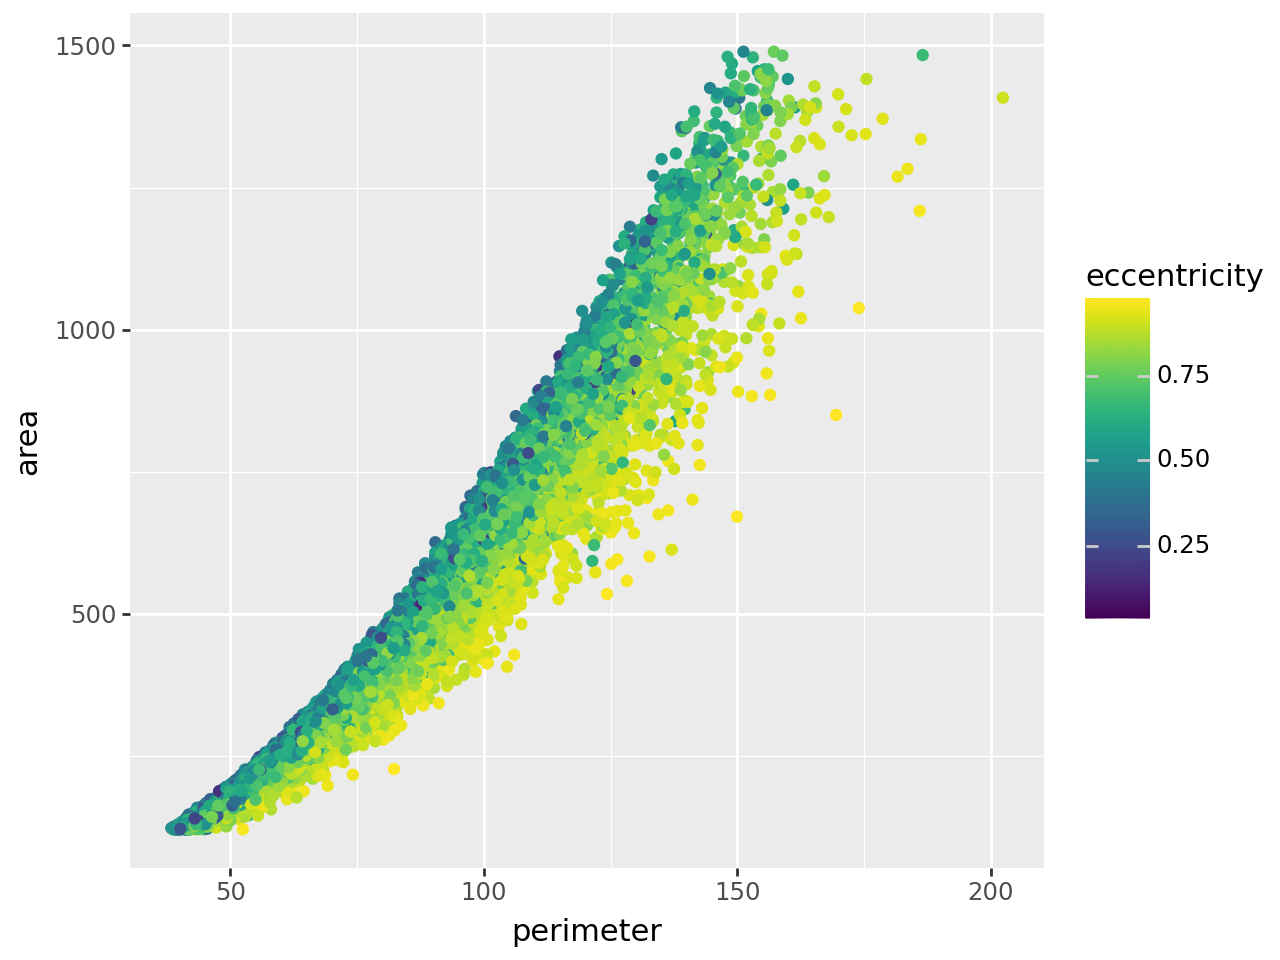

In [95]:
# Information appears correlated but complementary
ggplot(cell_table.sample(20000), aes(x = 'perimeter', y = 'area', color = 'eccentricity')) + geom_point()

In [93]:
morpho_features = ['eccentricity', 'perimeter', 'area']

# We start by looking at the cell shape of cancer cells
df_morpho = cell_table.loc[cell_table.consensus == "Cancer_cell",morpho_features] 
# df_morpho.index = df_func.index.astype(str)
df_morpho = df_morpho.loc[meta.index].loc[epithelial_subset]
df_morpho["fov"] = meta.loc[epithelial_subset]["fov"]
# For mean and std
df_morpho_per_fov = df_morpho.groupby("fov").mean().join(df_morpho.groupby("fov").std(), rsuffix="_std")

assert meta_per_fov.index.equals(df_morpho_per_fov.index)

In [96]:
cross_val_score(
    XGBClassifier(
        n_estimators=100, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    df_morpho_per_fov.loc[meta_per_fov["inner"]],
    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
    cv=cv_folds_fov, 
    scoring='f1_macro')

array([0.26818182, 0.25925282, 0.28821945, 0.28854915])

In [97]:
def process_fold_morphology(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):      
        # Step 1: Define train and test subsets of the compositional data
        train_morphology = df_morpho_per_fov.loc[meta_per_fov["inner"]].iloc[train]
        test_morphology = df_morpho_per_fov.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]

        # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_morphology,
                LabelEncoder().fit_transform(train_meta))

        # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_morphology)

        # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [99]:
def test_estimator_morphology(estimators, depth):
    scores = [process_fold_morphology(train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.mean(scores)
    # Append to f1 score log file
    with open(f"../../data/model5_cell_morphology_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    print(estimators, depth, mean_score)
    return mean_score

In [100]:
# Parallelize the hyperparameter loop
estimator_range = np.arange(15, 511, 10)
depth_range = np.arange(3, 10, 2)
estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
Parallel(n_jobs=28)(delayed(test_estimator_morphology)(r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()))

15 3 0.23931948030864042
25 3 0.23816928794127154
35 3 0.2508799069078981
55 3 0.26389883020141164
45 3 0.249162590282689
65 3 0.2674702164618229
75 3 0.2704582089907497
85 3 0.2679782700069048
95 3 0.28011434415531594
105 3 0.27166377937708625
115 3 0.27467985668250716
125 3 0.2617660631062712
135 3 0.26878840310503116
145 3 0.27594447499525
155 3 0.2832041446182533
165 3 0.2860011570736143
175 3 0.28368116751482225
185 3 0.2841539061417123
195 3 0.2833282810825007
205 3 0.2809792067725333
215 3 0.28667134158100216
225 3 0.2806428989207992
235 3 0.2851989508437755
245 3 0.282195395466717
15 5 0.250987297155214
255 3 0.285350659877746
265 3 0.2813483253597384
275 3 0.27872592663478135
25 5 0.27436312524331785
285 3 0.27872592663478135
35 5 0.2605072535559901
295 3 0.27872592663478135
45 5 0.26496237617324037
305 3 0.28126324937016023
55 5 0.26484183077758106
315 3 0.2731322184539351
65 5 0.26469289292983894
325 3 0.27314338839958086
75 5 0.26469289292983894
335 3 0.2730415505822258
85 

[0.23931948030864042,
 0.23816928794127154,
 0.2508799069078981,
 0.249162590282689,
 0.26389883020141164,
 0.2674702164618229,
 0.2704582089907497,
 0.2679782700069048,
 0.28011434415531594,
 0.27166377937708625,
 0.27467985668250716,
 0.2617660631062712,
 0.26878840310503116,
 0.27594447499525,
 0.2832041446182533,
 0.2860011570736143,
 0.28368116751482225,
 0.2841539061417123,
 0.2833282810825007,
 0.2809792067725333,
 0.28667134158100216,
 0.2806428989207992,
 0.2851989508437755,
 0.282195395466717,
 0.285350659877746,
 0.2813483253597384,
 0.27872592663478135,
 0.27872592663478135,
 0.27872592663478135,
 0.28126324937016023,
 0.2731322184539351,
 0.27314338839958086,
 0.2730415505822258,
 0.27328563914373527,
 0.27350972709253357,
 0.2724402105987838,
 0.2770221331224618,
 0.2758460600343563,
 0.2808594290183135,
 0.28342353158241607,
 0.28342353158241607,
 0.28342353158241607,
 0.28162919065764036,
 0.28499399827549676,
 0.28636762464912313,
 0.2861837299530333,
 0.28636762464912

In [137]:
pd.read_csv("../../data/model5_cell_morphology_f1_scores.txt", header=None, names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

,estimators,depth,score
138,75,9,0.296315
140,85,9,0.294424
143,95,9,0.294078
136,65,9,0.290591
147,115,9,0.288445
145,105,9,0.288445
124,15,9,0.288304
134,55,9,0.287806
72,505,3,0.287603
20,215,3,0.286671


[[ 14   0   0   0]
 [  0  68   0   0]
 [  0   0 174   0]
 [  0   0   0  78]]


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig4/morpho_importance_correctly_predicted_samples.pdf


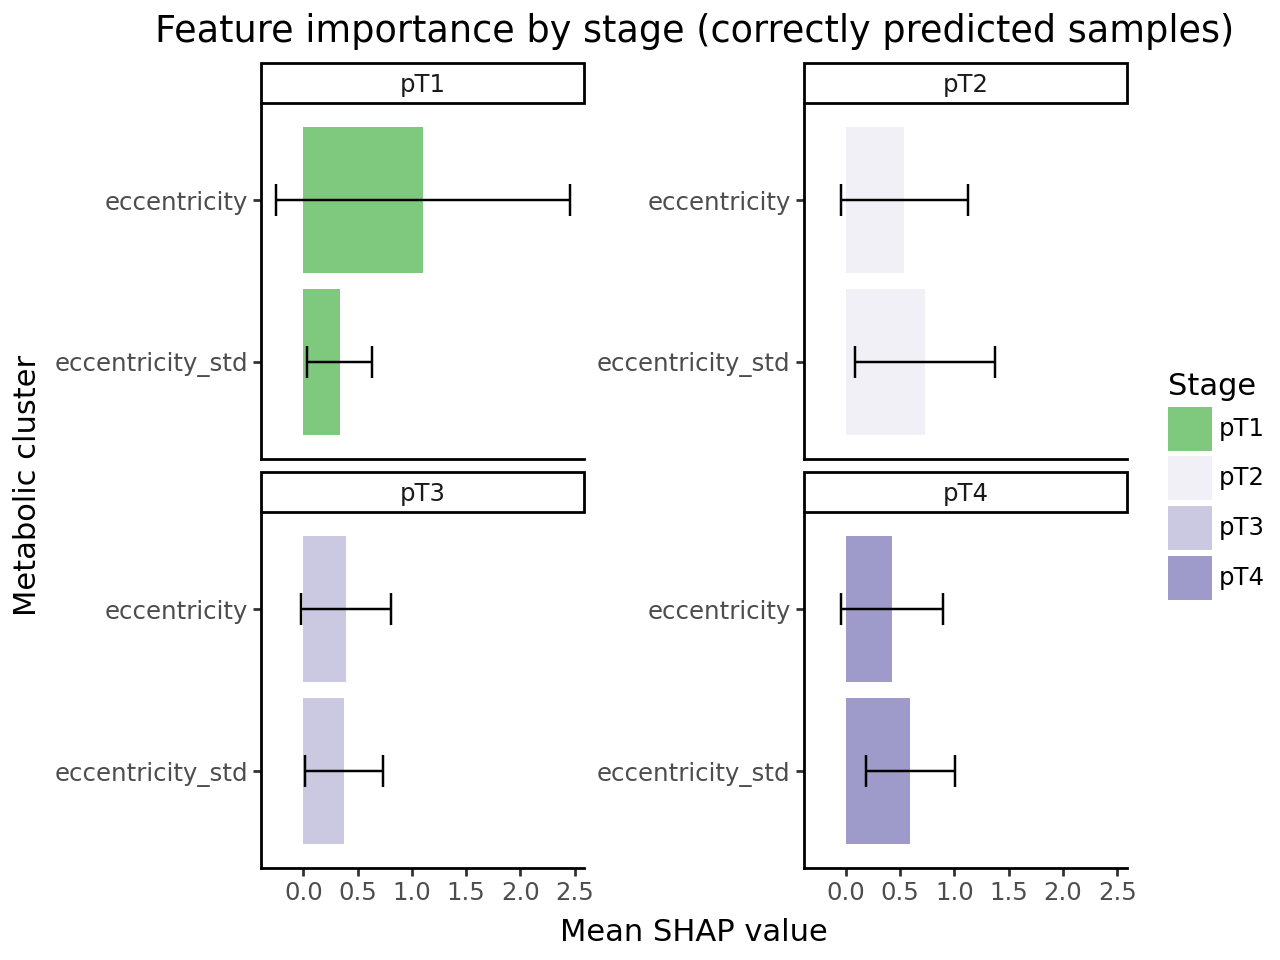

In [138]:
train_fov = df_morpho_per_fov.loc[meta_per_fov["inner"]]
original_stages = meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(original_stages)

xgb = XGBClassifier(
    n_estimators=75, 
    max_depth=9, 
    device="cuda", 
    random_state=0)
xgb.fit(train_fov,
        true_labels)

explainer = shap.Explainer(xgb)
shap_values = explainer(train_fov)

# Purples + Green for healthy
pal_stages = [(127,201,127), (242,240,247), (203,201,226), (158,154,201), (106,81,163)]
# Convert to hex
pal_stages = ['#%02x%02x%02x' % (r, g, b) for r, g, b in pal_stages]

predicted_labels = xgb.predict(train_fov)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Few errors on training set, so not meaningful to interpret misclassified FOVs

# For each stage, see how the true positive samples were predicted (SHAP values)

# Get indices of correctly predicted samples for each class
correct_indices = {class_idx: np.where((true_labels == class_idx) & (predicted_labels == class_idx))[0] 
                   for class_idx in range(conf_matrix.shape[0])}

shap_values_list = []
for class_idx, indices in correct_indices.items():
    shap_values_class = pd.DataFrame(shap_values.values[indices, :, class_idx], 
                                     columns=train_fov.columns)
    shap_values_class['fov'] = train_fov.index[indices]
    shap_values_class['class'] = label_encoder.inverse_transform([class_idx])[0]  # Use original stage names
    shap_values_list.append(shap_values_class)

shap_values_df = pd.concat(shap_values_list)

# Melt the DataFrame for easier plotting with plotnine
shap_values_melted = shap_values_df.melt(id_vars=['fov', 'class'], var_name='Feature', value_name='SHAP Value')

# Compute mean and std SHAP values for feature importance for each class
feature_importance = shap_values_melted.groupby(['class', 'Feature'])['SHAP Value'].agg(['mean', 'std']).reset_index()
# We want to display either high positive or high negative values
feature_importance["abs_mean"] = np.abs(feature_importance["mean"]) 
feature_importance = feature_importance.sort_values(by=['class', 'abs_mean'], ascending=[True, False])
feature_importance = feature_importance.loc[feature_importance.Feature.isin(feature_importance.groupby('class').head(1).Feature)]

# Add a column for reordering features
feature_importance['Feature'] = pd.Categorical(feature_importance['Feature'], 
                                               categories=feature_importance.groupby('class').head(1).Feature.unique()[::-1], 
                                               ordered=True)
feature_importance['class'] = feature_importance['class'].astype('category')

# Step 8: Visualize feature importance using plotnine
gp = (ggplot(feature_importance, 
                aes(x='Feature', y='mean', fill='class'))
      + geom_bar(stat='identity', position='dodge')
      + geom_errorbar(aes(ymin='mean-std', ymax='mean+std'), width=0.2, position='dodge')
      + coord_flip()
      + theme_classic()
      + scale_fill_manual(values=pal_stages)
      + labs(title='Feature importance by stage (correctly predicted samples)', x='Metabolic cluster', y='Mean SHAP value', fill='Stage')
      + facet_wrap('~class', scales='free_y'))

ggsave(gp, "../../figures/fig4/morpho_importance_correctly_predicted_samples.pdf", width=7, height=5)

gp.show()

In principle, we could as well look at the morphology of other cell types in the TME. However, this would require to make a lot of choices, as the FOVs with enough cells might not be the same, leading to non-trivial comparisons.

```Python
cells_per_fov = cell_table.groupby("fov").consensus.value_counts().unstack()
# Count NAs per type
cells_per_fov.isna().sum(axis="rows")
# We can also look at the morphology of CAF, NK_cell, CD4_Tcell, Monocyte,
# Endothelial_cell, Other_immune_cell

# morpho_features = ['eccentricity', 'perimeter', 'area']

# We now look at the cell shape of fibroblast cells
df_morpho = cell_table.loc[cell_table.consensus == "CAF",morpho_features] 

# Match meta dataframe
meta_morpho = cell_table.loc[cell_table.consensus == "CAF",["Stage","fov"]]
# Filter for well-annotated stages
meta_morpho = meta_morpho.loc[meta_morpho["Stage"].isin(["Colon-no.", "pT1", "pT2", "pT3", "pT4"])]
meta_morpho = meta_morpho.loc[~meta_morpho.fov.isin(
    meta_morpho.fov.value_counts()[meta_morpho.fov.value_counts() <= 3].index
    )]

df_morpho = df_morpho.loc[meta_morpho.index]
df_morpho["fov"] = meta_morpho["fov"]
# For mean only
# df_morpho_per_fov = df_morpho.groupby("fov").mean()
# For mean and std
df_morpho_per_fov = df_morpho.groupby("fov").mean().join(df_morpho.groupby("fov").std(), rsuffix="_std")
meta_morpho_per_fov = meta_morpho.groupby("fov").first()

assert meta_morpho_per_fov.index.equals(df_morpho_per_fov.index)

# Note: if the predictions are not done on the same FOVs, comparison is not possible
# and the cross-validation splits cannot be re-used
```

## Model 6: Functional features

In [131]:
func_features = ["STING1", "Ki67", "MSH2", "MSH6", "PDL1"]

# We start by looking at the cell shape of cancer cells
df_func = cell_table.loc[cell_table.consensus == "Cancer_cell",func_features] 
# df_morpho.index = df_morpho.index.astype(str)
df_func = df_func.loc[meta.index].loc[epithelial_subset]
df_func["fov"] = meta.loc[epithelial_subset]["fov"]
# For mean and std
df_func_per_fov = df_func.groupby("fov").mean().join(df_func.groupby("fov").std(), rsuffix="_std")

assert meta_per_fov.index.equals(df_func_per_fov.index)

In [132]:
def process_fold_func(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):      
        # Step 1: Define train and test subsets of the compositional data
        train_func = df_func_per_fov.loc[meta_per_fov["inner"]].iloc[train]
        test_func = df_func_per_fov.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]

        # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_func,
                LabelEncoder().fit_transform(train_meta))

        # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_func)

        # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [133]:
def test_estimator_func(estimators, depth):
    scores = [process_fold_func(train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.mean(scores)
    # Append to f1 score log file
    with open(f"../../data/model6_functional_markers_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    print(estimators, depth, mean_score)
    return mean_score

In [134]:
# Parallelize the hyperparameter loop
estimator_range = np.arange(15, 511, 10)
depth_range = np.arange(3, 10, 2)
estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
Parallel(n_jobs=28)(delayed(test_estimator_func)(r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()));

15 3 0.23338177092092016
25 3 0.24861037148299214
35 3 0.23823555412916397
45 3 0.2506761253528495
65 3 0.2451921563300006
55 3 0.2441388123599951
75 3 0.24374606519568098
85 3 0.2506299791187607
95 3 0.25032361288689264
105 3 0.25142228603376027
235 3 0.2594177367343662
115 3 0.25128144767876104
125 3 0.25259413027531064
135 3 0.2583524064972965
145 3 0.2677926050400839
155 3 0.26156237625780565
165 3 0.26228089008807853
175 3 0.25968516123492724
185 3 0.2660372914272435
195 3 0.2635826811834876
205 3 0.2681255934976856
215 3 0.2670090869754134
225 3 0.2698336384228695
245 3 0.25820233017777916
15 5 0.24527171454794974
255 3 0.2593251077781199
265 3 0.25548395050252726
275 3 0.2593251077781199
25 5 0.24894701403322095
285 3 0.25548395050252726
295 3 0.2568958792207541
35 5 0.2493538303930074
45 5 0.2410492806756941
305 3 0.2568958792207541
55 5 0.23907414286720174
315 3 0.26073703649634666
65 5 0.24138088768541444
325 3 0.26073703649634666
75 5 0.24158117888016212
335 3 0.255378183460

In [135]:
df_func_per_fov

,STING1,Ki67,MSH2,MSH6,PDL1,STING1_std,Ki67_std,MSH2_std,MSH6_std,PDL1_std
fov,,,,,,,,,,
A1a,0.005314,0.011476,0.021968,0.004899,0.012197,0.005916,0.012927,0.032632,0.007965,0.014323
A1c,0.102348,0.143395,0.377248,0.188367,0.048364,0.049547,0.122501,0.183860,0.133546,0.048286
A1d,0.062143,0.113486,0.167524,0.054071,0.088718,0.038943,0.105099,0.133571,0.045722,0.059723
A1e,0.075010,0.068422,0.152767,0.066609,0.059544,0.030814,0.077026,0.112073,0.058186,0.034958
A1f,0.042529,0.071826,0.237188,0.122306,0.060991,0.025517,0.080927,0.138084,0.084376,0.032381
...,...,...,...,...,...,...,...,...,...,...
D9c,0.137310,0.229638,0.648908,0.436575,0.020167,0.073723,0.218636,0.196970,0.239286,0.031124
D9e,0.260355,0.061636,0.151706,0.026212,0.021100,0.120663,0.124710,0.139697,0.035336,0.027142
D9f,0.139391,0.192409,0.244053,0.187080,0.073144,0.086075,0.246039,0.213453,0.198883,0.103682


In [136]:
pd.read_csv("../../data/model6_functional_markers_f1_scores.txt", 
            header=None, 
            names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

,estimators,depth,score
22,225,3,0.269834
20,205,3,0.268126
14,145,3,0.267793
21,215,3,0.267009
18,185,3,0.266037
72,505,3,0.264522
70,495,3,0.264522
19,195,3,0.263583
16,165,3,0.262281
15,155,3,0.261562
